# KNN Image Classification



## Imports and function definitions

In [3]:
import numpy as np
import pandas as pd 
import cv2
from glob import glob
import matplotlib.pyplot as plt
from skimage.feature import hog
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report
from sklearn.model_selection import KFold, cross_val_score
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

In [4]:
# Sumary stats function
def summary(array):
    min_val = np.min(array)
    max_val = np.max(array)
    sd = np.std(array)
    var = np.var(array)
    mean = np.mean(array)
    median = np.median(array)
    percentile25 = np.percentile(array, 25)
    percentile50 = np.percentile(array, 50)
    percentile75 = np.percentile(array, 75)
    
    summaryDict = {"max":max_val, 'min':min_val, "mean":mean, "median":median, "SD": sd, 
                   "var":var, "25th":percentile25, "50th": percentile50, "75th":percentile75 }
    return summaryDict

In [43]:
# plotting func to visulize correct and incorrect predictions of each class
def plot_hist_pred_vs_truth(y_pred, y_test):
    unique_labels = ['pure', 'broken', 'discolored', 'silkcut']
    n_classes = len(unique_labels)
    
    # get ture label counts 
    true_counts = pd.Series(y_test).value_counts()
    
    # count correct and incorrect occurences for each class
    correct_counts = [0,0,0,0]
    incorrect_counts = [0,0,0,0]
    for i in range(len(y_test)):
        if y_pred[i] == 'pure': 
            if y_test[i] == 'pure':
                correct_counts[0] += 1
            else:
                incorrect_counts[0] += 1
            continue
        if y_pred[i] == 'broken': 
            if y_test[i] == 'broken':
                correct_counts[1] += 1
            else:
                incorrect_counts[1] += 1
            continue
        if y_pred[i] == 'discolored': 
            if y_test[i] == 'discolored':
                correct_counts[2] += 1
            else:
                incorrect_counts[2] += 1
            continue
        if y_pred[i] == 'silkcut': 
            if y_test[i] == 'silkcut':
                correct_counts[3] += 1
            else:
                incorrect_counts[3] += 1
 
 
    plt.figure()
    plt.bar(unique_labels, true_counts)
    plt.xlabel('Class Label')
    plt.ylabel('Frequency')
    plt.title('Original Distribution of Samples')
    plt.xticks(unique_labels)

    # Plot the predicted label distribution with incorrect predictions stacked on top
    plt.figure()
    plt.bar(unique_labels, correct_counts, label='Correct')
    plt.bar(unique_labels, incorrect_counts, bottom=correct_counts, label='Incorrect')
    plt.xlabel('Class Label')
    plt.ylabel('Frequency')
    plt.title('Predicted Distribution of Samples')
    plt.xticks(unique_labels)
    plt.legend()

    plt.show()


In [54]:
# plotting func for prediction results
def pred_class_hist(y_prediction_list, title = "Predictions Distribution"):
    pred_series = pd.Series(y_prediction_list)
    ax = pred_series.value_counts().plot(kind='bar')
    plt.xlabel('Labels')    
    plt.ylabel('Count')
    plt.title(title)

    for i, v in enumerate(pred_series.value_counts()):
        ax.text(x=i, y=v + 0.5, s=v, ha='center', fontsize=10)
        
    plt.show()

In [5]:
# center cropping function
def center_crop(img, target_size):
    h, w = img.shape[:2]
    th, tw = target_size

    if h < th or w < tw:
        raise ValueError("Target size should be smaller than the input image size")

    x = (w - tw) // 2
    y = (h - th) // 2
    cropped_img = img[y:y+th, x:x+tw]

    return cropped_img

## Load in and Preprocess Data

In [6]:
# list files 
img_folder = './corn/train/*.png'
corn = glob(img_folder)

# Load in label table: 
train_csv = pd.read_csv("./corn/train.csv")
print(train_csv.head())

# grab class labels 
labels = train_csv['label']
labels.head()

   seed_id    view            image       label
0        0     top  train/00000.png      broken
1        1  bottom  train/00001.png        pure
2        3     top  train/00003.png      broken
3        4     top  train/00004.png        pure
4        5     top  train/00005.png  discolored


0        broken
1          pure
2        broken
3          pure
4    discolored
Name: label, dtype: object

In [7]:

# preprocess images: center crop and normalization 
target_size = (140,140)
croppedImages = []

for imgPth in corn:
    temp_img = cv2.imread(imgPth)
    if (temp_img.shape[0] >= target_size[0] & temp_img.shape[1] >= target_size[1]):
        croppedimg = center_crop(temp_img, target_size)
        croppedimg = (croppedimg / 255).astype(np.float32) # normalize
        croppedImages.append(croppedimg)
    else:
        resizedImg = cv2.resize(temp_img, target_size)
        resizedImg = (resizedImg / 255).astype(np.float32) # normalize
        croppedImages.append(resizedImg)

# Greyscale conversion and HOG feature extraction 
croppedImages_grey = [cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) for img in croppedImages]

hog_features = [hog(img, orientations=9, pixels_per_cell=(8,8), cells_per_block=(2,2)) for img in croppedImages_grey]

In [8]:
# Inspect HOG features 
summary(hog_features)

# shape of HOG features 
print(len(hog_features[0]))
print(len(hog_features))

9216
14322


## Split Data, Train and Predict with Un-tuned Hyperparmeters


In [9]:
# split data, train model, make predictions
X_train, X_test, y_train, y_test = train_test_split(hog_features, labels, test_size=0.2, random_state=265)

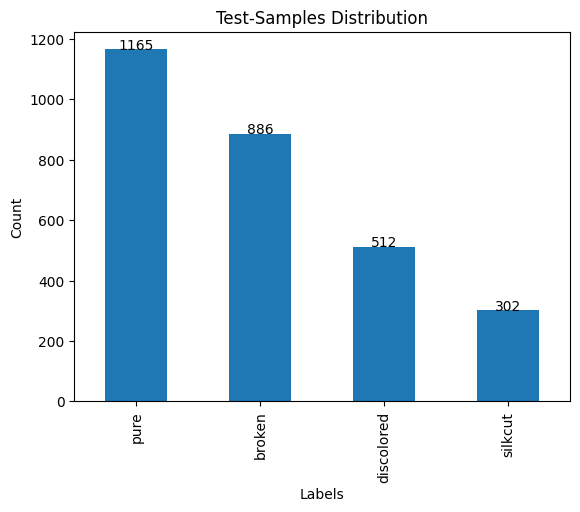

In [55]:
# original test sample distribution: 
pred_class_hist(y_test, title = "Test-Samples Distribution")

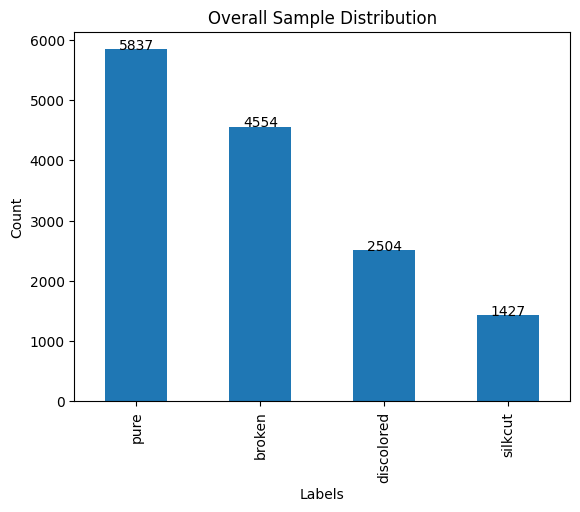

In [56]:
# overall distribution of samples 
pred_class_hist(labels, title = "Overall Sample Distribution")

In [10]:
# train classifer with naive settings, before grid search to establish baseline performance
knn = KNeighborsClassifier(n_neighbors=10)
knn.fit(X_train, y_train)

# Evaluate the classifier on the test set
y_pred = knn.predict(X_test)
print(classification_report(y_test, y_pred, digits = 4))

              precision    recall  f1-score   support

      broken     0.6702    0.0711    0.1286       886
  discolored     0.2500    0.0039    0.0077       512
        pure     0.4172    0.9845    0.5861      1165
     silkcut     0.7857    0.0364    0.0696       302

    accuracy                         0.4269      2865
   macro avg     0.5308    0.2740    0.1980      2865
weighted avg     0.5044    0.4269    0.2868      2865



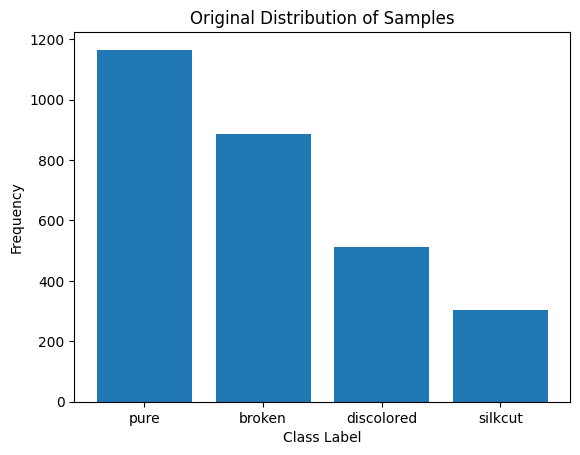

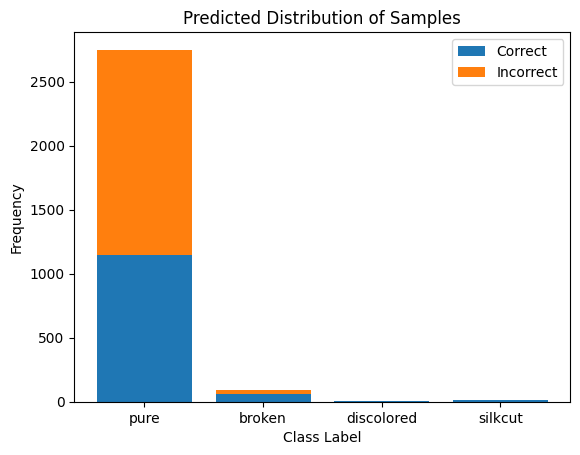

In [51]:
# View prediction results
plot_hist_pred_vs_truth(y_pred, y_test.tolist())

## Perform PCA on HOG - Then Cross Validation to find Best Hyperparameters
### (further preprocessing which will improve final results)

In [12]:
# 1000 components for hyperparameter tunning 
pca = PCA(n_components=1000) 
pca.fit(hog_features)
pca_hog_features = pca.transform(hog_features)

# Train Test Split for PCA data
X_train_pca, X_test_pca, y_train_pca, y_test_pca = train_test_split(pca_hog_features, labels, test_size=0.2, random_state=65)

In [13]:
# cross validation to find best number of folds and best number of PCA componenets
folds = 5
kf = KFold(n_splits=folds, shuffle=True, random_state=20)

num_neighbors = [3, 7, 9, 13, 20, 35, 50, 65, 90, 100]
num_pca_comp = [10, 15, 20, 25, 35, 50, 100, 250, 500, 1000]

# Initialize an empty dict to store the average accuracy for each number of neighbors and components
best_params = {'n_neighbors': None, 'n_components': None, 'accuracy': 0}

for neighbors in num_neighbors:
    for n_components in num_pca_comp:
        
        # Create a KNN classifier with the current number of neighbors
        knn = KNeighborsClassifier(n_neighbors=neighbors)

        # Calculate the cross-validated accuracy for the current number of neighbors and components
        cv_accuracies = cross_val_score(knn, X_train_pca[:, :n_components], y_train_pca, cv=kf, scoring='accuracy')
        
        # Compute the average accuracy across the folds
        avg_accuracy = np.mean(cv_accuracies)

        # Update accuracy if better
        if avg_accuracy > best_params['accuracy']:
            best_params['n_neighbors'] = neighbors
            best_params['n_components'] = n_components
            best_params['accuracy'] = avg_accuracy


print(f"Best parameters: {best_params}")

Best parameters: {'n_neighbors': 50, 'n_components': 35, 'accuracy': 0.5021401751904219}


In [14]:
# train model with best hyperparameters after cross validation grid search
knn = KNeighborsClassifier(n_neighbors=best_params['n_neighbors'])
knn.fit(X_train_pca[:, :best_params['n_components']], y_train_pca)
y_pred_pca = knn.predict(X_test_pca[:, :best_params['n_components']])
print(classification_report(y_test_pca, y_pred_pca, digits = 4))

              precision    recall  f1-score   support

      broken     0.6174    0.4651    0.5305       916
  discolored     0.5000    0.0135    0.0262       520
        pure     0.4822    0.8930    0.6262      1150
     silkcut     0.6129    0.0681    0.1226       279

    accuracy                         0.5162      2865
   macro avg     0.5531    0.3599    0.3264      2865
weighted avg     0.5414    0.5162    0.4377      2865



In [47]:
print(y_pred_pca[:10], y_test_pca[:10])
print(type(y_pred_pca), type(y_test_pca))

['pure' 'pure' 'pure' 'broken' 'pure' 'broken' 'pure' 'pure' 'pure'
 'broken'] 3773         broken
9959           pure
807            pure
9821           pure
866            pure
12417          pure
1062     discolored
566         silkcut
8549           pure
9648         broken
Name: label, dtype: object
<class 'numpy.ndarray'> <class 'pandas.core.series.Series'>


C:\Users\Tanner_N\AppData\Local\Temp\ipykernel_9952\592122758.py:1: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  print(y_pred_pca[:10], y_test_pca[:10])


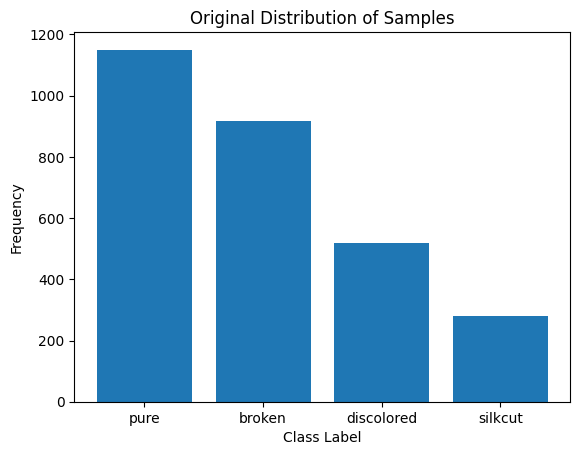

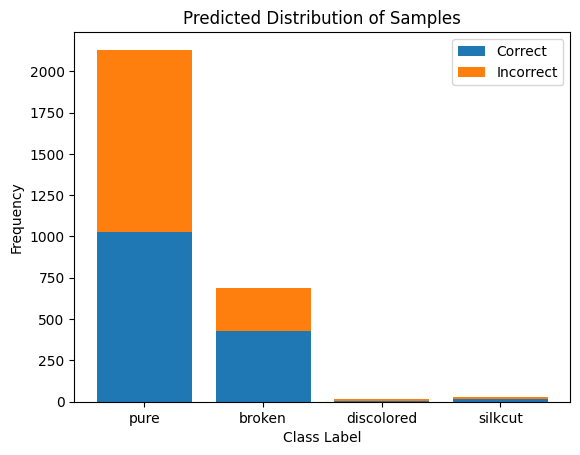

In [50]:
# View prediction results
plot_hist_pred_vs_truth(y_pred_pca, y_test_pca.tolist())

## Perform SIFT Feature Extraction and test with Naive Hyperparmeters



In [16]:
# convert images to uint8 format such that detectAndCompute can be used; 
# un-normalizing the images as well, SIFT will detect no points of interest on normalized data for this data set
croppedImages_grey_uint8 = [np.uint8(img * 255) for img in croppedImages_grey]

In [17]:
# SIFT Feature Extraction and Train Test Split Func: 
def SIFT_extract_and_split(uint8_images, class_labels, no_split = False, train_test_random_state = 51, k_clusters = 50, print_num_featureless_images = True, SIFT_edgeThresh = 10, SIFT_sigma = 1.5):
    # Extract SIFT features
  sift = cv2.SIFT_create(edgeThreshold=SIFT_edgeThresh, sigma=SIFT_sigma)
  sift_features = [sift.detectAndCompute(img, None)[1] for img in uint8_images]
  
  # count none values, grab indices. (Since some images can fail to produce any points of interest for SIFT, they will be returned as None objects which need to be removed.) 
  none_count = 0
  none_idx = []
  for idx, features in enumerate(sift_features):
      if features is None:
          none_count+=1
          none_idx.append(idx)
          
  if print_num_featureless_images:
    print(none_count)
  
  # removing bad indices from sift_features and labels
  sift_features = [itm for idx, itm in enumerate(sift_features) if idx not in none_idx]
  sift_labels = [itm for idx, itm in enumerate(class_labels) if idx not in none_idx]
  
    # Stack all feature vectors
  all_features = np.vstack(sift_features)
  
  # Create visual vocabulary using k-means clustering
  # num of clusters == num visual words
  kmeans = KMeans(n_clusters=k_clusters, random_state=train_test_random_state)
  kmeans.fit(all_features)
  
  # Generate histograms of visual words for each image
  image_histograms = []
  for feature in sift_features:
      histogram = np.zeros(k_clusters)
      clusters = kmeans.predict(feature)
      for cluster in clusters:
          histogram[cluster] += 1
      image_histograms.append(histogram)
  
  if no_split:
    return image_histograms, sift_labels
  
    # split up new data features 
  X_train_sift, X_test_sift, y_train_sift, y_test_sift = train_test_split(image_histograms, sift_labels, test_size=0.2, random_state=51)
  
  return X_train_sift, X_test_sift, y_train_sift, y_test_sift


In [18]:
# SIFT extraction and split return
X_train_sift, X_test_sift, y_train_sift, y_test_sift = SIFT_extract_and_split(croppedImages_grey_uint8, labels, k_clusters=100)

knn_sift = KNeighborsClassifier(n_neighbors=25)
knn_sift.fit(X_train_sift, y_train_sift)

96


c:\Users\Tanner_N\AppData\Local\Python\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


KNeighborsClassifier(n_neighbors=25)

In [19]:
# Evaluate the classifier on the test set
y_pred_sift = knn_sift.predict(X_test_sift)
print(classification_report(y_test_sift, y_pred_sift, digits = 4))

              precision    recall  f1-score   support

      broken     0.6022    0.1214    0.2020       898
  discolored     0.4805    0.0743    0.1287       498
        pure     0.4342    0.9739    0.6006      1151
     silkcut     0.8333    0.0167    0.0328       299

    accuracy                         0.4469      2846
   macro avg     0.5876    0.2966    0.2410      2846
weighted avg     0.5372    0.4469    0.3326      2846



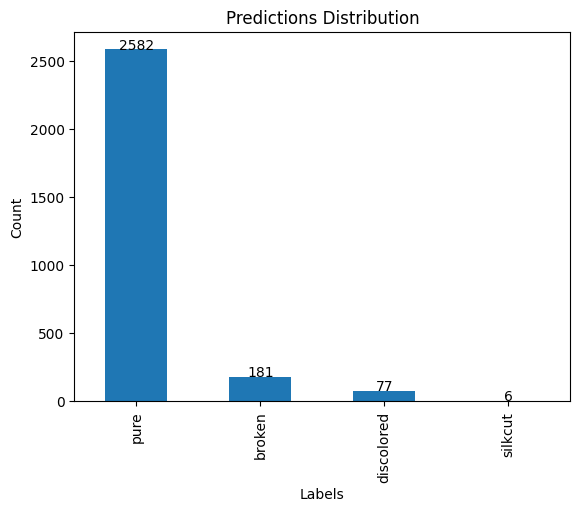

In [20]:
plot_hist_pred_vs_truth(y_pred_sift, y_test_sift.tolist()) 

## Cross Validation on SIFT --> PCA --> KNN 

In [21]:
# small # of folds, as this process is computationally expensive
folds = 2
kf = KFold(n_splits=folds, shuffle=True, random_state=20)

num_clusters = [30, 80, 130]
num_neighbors = [8, 15, 35, 65, 100]
num_pca_comp = [10, 15, 20, 25, 30]

# Initialize an empty dict to store the average accuracy for each number of neighbors and components
best_params = {'num_clusters': None, 'n_neighbors': None, 'n_components': None, 'accuracy': 0}

for clusters in num_clusters:
    # create SIFT feature extraction, run PCA on it, then split into trian test split
  image_hists, labs = SIFT_extract_and_split(croppedImages_grey_uint8, labels, k_clusters=clusters, no_split=True, SIFT_edgeThresh=15, SIFT_sigma=.5)
  pca_sift = PCA(n_components=30)
  image_hists_PCA = pca_sift.fit_transform(image_hists)
  X_train_sift_pca, X_test_sift_pca, y_train_sift_pca, y_test_sift_pca = train_test_split(image_hists_PCA, labs, test_size=0.2, random_state=13)
  
  for neighbors in num_neighbors:
      for n_components in num_pca_comp:
          
          # Create a KNN classifier with the current number of neighbors
          knn = KNeighborsClassifier(n_neighbors=neighbors)
  
          # Calculate the cross-validated accuracy for the current number of neighbors   and components
          cv_accuracies = cross_val_score(knn, X_train_sift_pca[:, :n_components],   y_train_sift_pca, cv=kf, scoring='accuracy')
          
          # Compute the average accuracy across the folds
          avg_accuracy = np.mean(cv_accuracies)
  
          # Update accuracy if better
          if avg_accuracy > best_params['accuracy']:
              best_params['num_clusters'] = clusters
              best_params['n_neighbors'] = neighbors
              best_params['n_components'] = n_components
              best_params['accuracy'] = avg_accuracy

161


c:\Users\Tanner_N\AppData\Local\Python\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


161


c:\Users\Tanner_N\AppData\Local\Python\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


161


c:\Users\Tanner_N\AppData\Local\Python\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [22]:
print(f"Best parameters: {best_params}")

Best parameters: {'num_clusters': 30, 'n_neighbors': 65, 'n_components': 10, 'accuracy': 0.5313382768361582}


## Train KNN with best Hyperparameters for PCA and SIFT Extraction

In [23]:
img_hists, labs = SIFT_extract_and_split(croppedImages_grey_uint8, labels, k_clusters=25, SIFT_edgeThresh=15, SIFT_sigma=0.5, no_split=True)

161


c:\Users\Tanner_N\AppData\Local\Python\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [24]:
pca_sift = PCA(n_components=10)
img_hists = pca_sift.fit_transform(img_hists)

X_train_sift, X_test_sift, y_train_sift, y_test_sift = train_test_split(img_hists, labs, test_size=0.2, random_state=525)
knn_sift_2 = KNeighborsClassifier(n_neighbors=65)
knn_sift_2.fit(X_train_sift, y_train_sift)

KNeighborsClassifier(n_neighbors=65)

In [25]:
# Evaluate the classifier on the test set
y_pred_sift_2 = knn_sift_2.predict(X_test_sift)
print(classification_report(y_test_sift, y_pred_sift_2, digits = 4))

              precision    recall  f1-score   support

      broken     0.4900    0.5006    0.4952       883
  discolored     0.4246    0.1456    0.2168       522
        pure     0.5638    0.8455    0.6765      1165
     silkcut     0.4000    0.0076    0.0149       263

    accuracy                         0.5312      2833
   macro avg     0.4696    0.3748    0.3509      2833
weighted avg     0.5000    0.5312    0.4739      2833



<class 'numpy.ndarray'> <class 'list'>


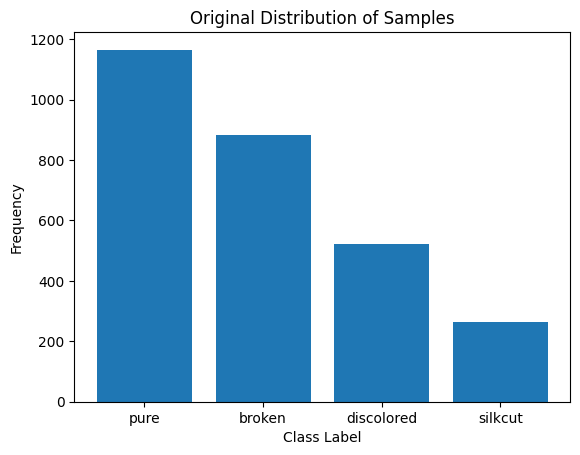

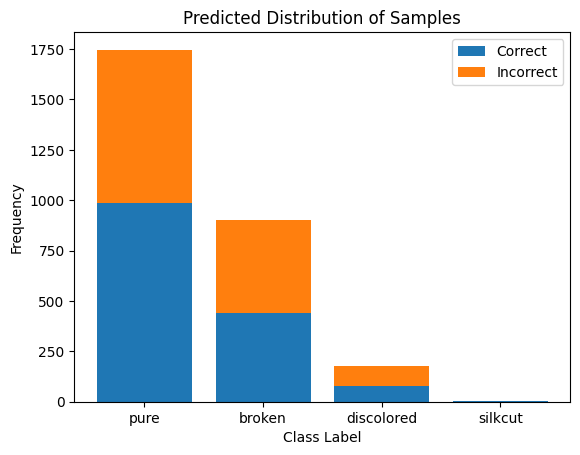

In [49]:

print(type(y_pred_sift_2), type(y_test_sift))
plot_hist_pred_vs_truth(y_pred_sift_2, y_test_sift)